313/313 - 1s - loss: 0.0372 - sparse_categorical_accuracy: 0.9895 - 1s/epoch - 5ms/step
157/157 - 1s - loss: 4.2405 - sparse_categorical_accuracy: 0.2556 - 868ms/epoch - 6ms/step
157/157 - 1s - loss: 2.2345 - sparse_categorical_accuracy: 0.0144 - 617ms/epoch - 4ms/step
157/157 - 1s - loss: 1.3042 - sparse_categorical_accuracy: 0.0144 - 649ms/epoch - 4ms/step
Epoch 1/5
200/200 - 4s - loss: 0.8783 - sparse_categorical_accuracy: 0.7340 - 4s/epoch - 20ms/step
313/313 - 1s - loss: 0.1133 - sparse_categorical_accuracy: 0.9646 - 1s/epoch - 3ms/step
157/157 - 1s - loss: 0.5028 - sparse_categorical_accuracy: 0.8328 - 572ms/epoch - 4ms/step
157/157 - 1s - loss: 0.2999 - sparse_categorical_accuracy: 0.9000 - 565ms/epoch - 4ms/step
157/157 - 1s - loss: 0.2890 - sparse_categorical_accuracy: 0.9026 - 563ms/epoch - 4ms/step
Epoch 2/5
200/200 - 3s - loss: 0.3515 - sparse_categorical_accuracy: 0.8853 - 3s/epoch - 17ms/step
313/313 - 1s - loss: 0.1179 - sparse_categorical_accuracy: 0.9631 - 1s/epoch - 4

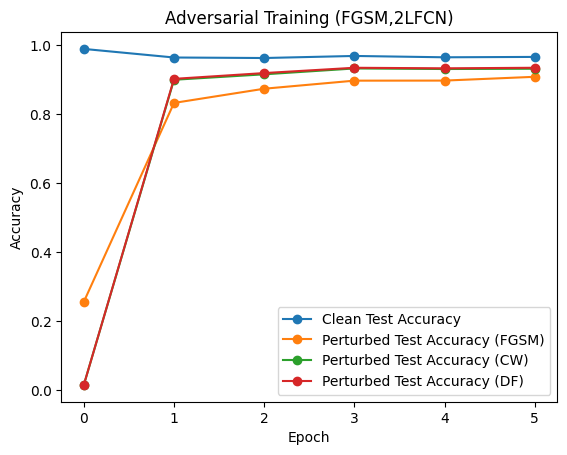

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

# Load the perturbed fgsm training dataset
perturbed_train_data = np.load('../AttackMethods/perturbed_mnist_2LFCN_FGSM_train.npz')
perturbed_train_images = perturbed_train_data['images']
perturbed_train_labels = perturbed_train_data['labels']

# Load the clean test dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Normalize pixel values

# Load the perturbed fgsm test dataset
perturbed_test_data_FGSM = np.load('../AttackMethods/perturbed_mnist_2LFCN_FGSM_test.npz')
perturbed_test_images_FGSM = perturbed_test_data_FGSM['images']
perturbed_test_labels_FGSM = perturbed_test_data_FGSM['labels']

# Load the perturbed CW test dataset
perturbed_test_data_CW = np.load('../AttackMethods/perturbed_mnist_2LFCN_CW_test.npz')
perturbed_test_images_CW = perturbed_test_data_CW['images']
perturbed_test_labels_CW = perturbed_test_data_CW['labels']

# Load the perturbed DF test dataset
perturbed_test_data_DF = np.load('../AttackMethods/perturbed_mnist_2LFCN_DF_test.npz')
perturbed_test_images_DF = perturbed_test_data_DF['images']
perturbed_test_labels_DF = perturbed_test_data_DF['labels']


# Load the FCN model (replace with your model loading code)
fcn_model = models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Compile the model
fcn_model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

# Evaluate on clean test set before any adversarial training
test_loss, initial_clean_test_accuracy = fcn_model.evaluate(test_images, test_labels, verbose=2)

# Evaluate on perturbed test sets before any adversarial training
test_loss, initial_perturbed_test_accuracy_FGSM = fcn_model.evaluate(perturbed_test_images_FGSM, perturbed_test_labels_FGSM, verbose=2)
test_loss, initial_perturbed_test_accuracy_CW = fcn_model.evaluate(perturbed_test_images_CW, perturbed_test_labels_CW, verbose=2)
test_loss, initial_perturbed_test_accuracy_DF = fcn_model.evaluate(perturbed_test_images_DF, perturbed_test_labels_DF, verbose=2)


# Adversarial training parameters
epochs = 5
batch_size = 100

# Lists to store accuracy for plotting
clean_test_accuracies = [initial_clean_test_accuracy]
perturbed_test_accuracies_FGSM = [initial_perturbed_test_accuracy_FGSM]
perturbed_test_accuracies_CW = [initial_perturbed_test_accuracy_CW]
perturbed_test_accuracies_DF = [initial_perturbed_test_accuracy_DF]


# Adversarial training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train on perturbed examples
    fcn_model.fit(perturbed_train_images, perturbed_train_labels, epochs=1, batch_size=batch_size, verbose=2)

    # Evaluate on clean test set
    test_loss, clean_test_accuracy = fcn_model.evaluate(test_images, test_labels, verbose=2)
    clean_test_accuracies.append(clean_test_accuracy)

    # Evaluate on perturbed test sets
    test_loss, perturbed_test_accuracy_FGSM = fcn_model.evaluate(perturbed_test_images_FGSM, perturbed_test_labels_FGSM, verbose=2)
    perturbed_test_accuracies_FGSM.append(perturbed_test_accuracy_FGSM)
    test_loss, perturbed_test_accuracy_CW = fcn_model.evaluate(perturbed_test_images_CW, perturbed_test_labels_CW, verbose=2)
    perturbed_test_accuracies_CW.append(perturbed_test_accuracy_CW)
    test_loss, perturbed_test_accuracy_DF = fcn_model.evaluate(perturbed_test_images_DF, perturbed_test_labels_DF, verbose=2)
    perturbed_test_accuracies_DF.append(perturbed_test_accuracy_DF)

# Plot the results
plt.plot(range(0, epochs + 1), clean_test_accuracies, label='Clean Test Accuracy', marker='o')
plt.plot(range(0, epochs + 1), perturbed_test_accuracies_FGSM, label='Perturbed Test Accuracy (FGSM)', marker='o')
plt.plot(range(0, epochs + 1), perturbed_test_accuracies_CW, label='Perturbed Test Accuracy (CW)', marker='o')
plt.plot(range(0, epochs + 1), perturbed_test_accuracies_DF, label='Perturbed Test Accuracy (DF)', marker='o')
plt.title('Adversarial Training (FGSM,2LFCN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
import tensorflow as tf

def generate_fgsm(image, model, epsilon):
    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        target_class = tf.argmax(prediction[0])
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_class, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)  # Ensure pixel values are in [0, 1] range
    
    return perturbed_image.numpy()[0]

In [64]:
import tensorflow as tf
import numpy as np

def generate_carlini_l2(image, model, epsilon, max_iter, learning_rate):
    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    # Initialize perturbed_image before the loop
    perturbed_image = tf.cast(image, dtype=tf.float32)

    # Define the objective function for the attack
    def objective_function(perturbed_image):
        prediction = model(perturbed_image)
        target_class = tf.argmax(prediction[0])
        f_x = prediction[0][target_class]
        return -f_x

    # Define the L2 norm penalty
    def l2_norm(perturbed_image):
        perturbed_image = tf.cast(perturbed_image, dtype=tf.float32)
        image_cast = tf.cast(image, dtype=tf.float32)
        return tf.reduce_sum(tf.square(perturbed_image - image_cast))

    # Define the gradient of the objective function
    @tf.custom_gradient
    def gradient_objective_function(perturbed_image):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image)
        gradient = tape.gradient(loss, perturbed_image)
        def grad(d_loss):
            return d_loss * gradient
        return loss, grad
    
    prediction = model(image)
    target_class = tf.argmax(prediction[0])

    for i in range(max_iter):
        # Step 1: Compute the gradient of the objective function
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            loss = objective_function(perturbed_image) + epsilon * l2_norm(perturbed_image)
        gradient, = tape.gradient(loss, perturbed_image)

        # Step 2: Project the gradient onto the L2 sphere
        gradient = tf.nn.l2_normalize(gradient, axis=1)

        # Step 3: Update the perturbed image
        perturbed_image = perturbed_image + learning_rate * gradient

        # Step 4: Clip pixel values and ensure image validity
        perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)

        # Step 5: Check if the image is now misclassified
        prediction = model(perturbed_image)
        if tf.argmax(prediction[0]) != target_class:
            break

    # Return the adversarial example
    return perturbed_image.numpy()[0]

In [63]:
import tensorflow as tf
import numpy as np

def generate_deepfool(image, model, epsilon=0.001, max_iter=100):
    # Ensure the image has the correct shape
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    # Initialize perturbed_image before the loop
    perturbed_image = image

    for i in range(int(max_iter)):  # Convert max_iter to an integer
        # print(i)
        # Step 1: Compute the gradient of the loss with respect to the input image
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            target_class = tf.argmax(prediction[0])
            loss = tf.keras.backend.sparse_categorical_crossentropy(target_class, prediction)

        gradient = tape.gradient(loss, image)
        gradient_norm = tf.linalg.norm(gradient)

        # Step 2: Compute the perturbation direction
        w = gradient / gradient_norm

        # Step 3: Compute the minimum perturbation required to reach the decision boundary
        f_x = prediction[0][target_class]
        perturbation = tf.reduce_sum(tf.abs(gradient)) / gradient_norm**2 * w
        r_star = tf.minimum(epsilon, tf.abs(f_x) / tf.cast(tf.linalg.norm(perturbation), tf.float32))

        # Step 4: Perturb the image and clip pixel values
        perturbed_image = image + tf.cast(r_star, perturbation.dtype) * perturbation
        perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)


        # Step 5: Check if the image is now misclassified
        prediction = model(perturbed_image)
        if tf.argmax(prediction[0]) != target_class:
            # print("Stopped")
            break

        # Update the original image
        image = perturbed_image

    # Return the adversarial example
    return perturbed_image.numpy()[0]

Epoch 1/25
313/313 [==============================] - 1s 4ms/step - loss: 0.0372 - sparse_categorical_accuracy: 0.9895
4/4 - 0s - loss: 3.2366 - sparse_categorical_accuracy: 0.3800 - 33ms/epoch - 8ms/step
4/4 - 0s - loss: 2.2782 - sparse_categorical_accuracy: 0.0100 - 37ms/epoch - 9ms/step
4/4 - 0s - loss: 1.4179 - sparse_categorical_accuracy: 0.0100 - 32ms/epoch - 8ms/step
32/32 - 1s - loss: 2.2938 - sparse_categorical_accuracy: 0.4700 - 1s/epoch - 47ms/step
Epoch 2/25
313/313 [==============================] - 1s 3ms/step - loss: 0.0800 - sparse_categorical_accuracy: 0.9761
4/4 - 0s - loss: 2.2808 - sparse_categorical_accuracy: 0.3700 - 32ms/epoch - 8ms/step
4/4 - 0s - loss: 1.5694 - sparse_categorical_accuracy: 0.0000e+00 - 30ms/epoch - 7ms/step
4/4 - 0s - loss: 0.9536 - sparse_categorical_accuracy: 0.0000e+00 - 28ms/epoch - 7ms/step
32/32 - 0s - loss: 1.7593 - sparse_categorical_accuracy: 0.4180 - 122ms/epoch - 4ms/step
Epoch 3/25
313/313 [==============================] - 1s 5ms/s

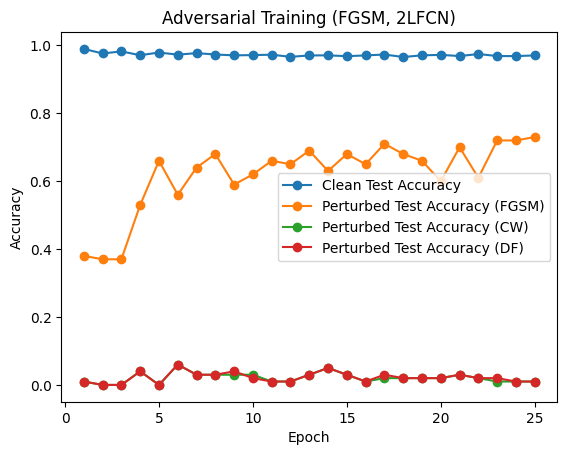

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

# Load the clean training dataset
(_, _), (train_images, train_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0  # Normalize pixel values

# Load the clean test dataset
(_, _), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = test_images / 255.0  # Normalize pixel values

# Load the FCN model (replace with your model loading code)
fcn_model = models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Compile the model
fcn_model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

# Adversarial training parameters
epochs = 25
batch_size = 16
epsilon_fgs = 0.25  # FGSM epsilon value

# Lists to store accuracy for plotting
clean_test_accuracies = []
perturbed_test_accuracies_FGSM = []
perturbed_test_accuracies_CW = []
perturbed_test_accuracies_DF = []

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.005
max_iter=50
learning_rate = 0.1

# Define parameters for the Deepfool attack
max_iter = 50
epsilon = 0.005

# Adversarial training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Randomly select a subset of 500 training samples
    indices_train = np.random.choice(len(train_images), 500, replace=False)
    train_images_200 = train_images[indices_train]
    perturbed_train_images = np.array([generate_fgsm(image, fcn_model, epsilon_fgs) for image in train_images_200])
    perturbed_train_labels = train_labels[indices_train]

    # Randomly select a subset of 100 testing samples and generate adversarial examples
    indices_test = np.random.choice(len(test_images), 100, replace=False)
    test_images_200 = test_images[indices_test]
    #FGSM
    perturbed_test_images_FGSM = np.array([generate_fgsm(image, fcn_model, epsilon_fgs) for image in test_images_200])
    perturbed_test_labels_FGSM = test_labels[indices_test]
    #CW
    perturbed_test_images_CW = np.array([generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate) for image in test_images_200])
    perturbed_test_labels_CW = test_labels[indices_test]
    #DF
    perturbed_test_images_DF = np.array([generate_deepfool(image, fcn_model, epsilon, max_iter) for image in test_images_200])
    perturbed_test_labels_DF = test_labels[indices_test]

    # Evaluate on clean test set
    test_loss, clean_test_accuracy = fcn_model.evaluate(test_images, test_labels)
    clean_test_accuracies.append(clean_test_accuracy)

    # Evaluate on perturbed test sets
    perturbed_test_accuracy_FGSM = fcn_model.evaluate(perturbed_test_images_FGSM, perturbed_test_labels_FGSM, verbose=2)[1]
    perturbed_test_accuracies_FGSM.append(perturbed_test_accuracy_FGSM)
    perturbed_test_accuracy_CW = fcn_model.evaluate(perturbed_test_images_CW, perturbed_test_labels_CW, verbose=2)[1]
    perturbed_test_accuracies_CW.append(perturbed_test_accuracy_CW)
    perturbed_test_accuracy_DF = fcn_model.evaluate(perturbed_test_images_DF, perturbed_test_labels_DF, verbose=2)[1]
    perturbed_test_accuracies_DF.append(perturbed_test_accuracy_DF)

    # Train on perturbed examples
    fcn_model.fit(perturbed_train_images, perturbed_train_labels, epochs=1, batch_size=batch_size, verbose=2)

# Plot the results
plt.plot(range(1, epochs+1), clean_test_accuracies, label='Clean Test Accuracy', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_FGSM, label='Perturbed Test Accuracy (FGSM)', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_CW, label='Perturbed Test Accuracy (CW)', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_DF, label='Perturbed Test Accuracy (DF)', marker='o')
plt.title('Adversarial Training (FGSM, 2LFCN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [73]:
fcn_model.save("../Models/Mnist/mnist_model_2LFCN_ADV_FGSM.karas")

INFO:tensorflow:Assets written to: ../Models/Mnist/mnist_model_2LFCN_ADV_FGSM.karas\assets


INFO:tensorflow:Assets written to: ../Models/Mnist/mnist_model_2LFCN_ADV_FGSM.karas\assets


Epoch 1/25
313/313 [==============================] - 3s 7ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9899
4/4 - 0s - loss: 3.5065 - sparse_categorical_accuracy: 0.2900 - 77ms/epoch - 19ms/step
4/4 - 0s - loss: 2.0660 - sparse_categorical_accuracy: 0.0200 - 78ms/epoch - 19ms/step
4/4 - 0s - loss: 1.1889 - sparse_categorical_accuracy: 0.0200 - 46ms/epoch - 12ms/step
32/32 - 2s - loss: 2.3139 - sparse_categorical_accuracy: 0.4280 - 2s/epoch - 60ms/step
Epoch 2/25
313/313 [==============================] - 1s 4ms/step - loss: 0.0889 - sparse_categorical_accuracy: 0.9745
4/4 - 0s - loss: 2.1943 - sparse_categorical_accuracy: 0.3400 - 39ms/epoch - 10ms/step
4/4 - 0s - loss: 1.4684 - sparse_categorical_accuracy: 0.0100 - 48ms/epoch - 12ms/step
4/4 - 0s - loss: 0.8833 - sparse_categorical_accuracy: 0.0100 - 59ms/epoch - 15ms/step
32/32 - 0s - loss: 1.8909 - sparse_categorical_accuracy: 0.4160 - 196ms/epoch - 6ms/step
Epoch 3/25
313/313 [==============================] - 2s 6ms/ste

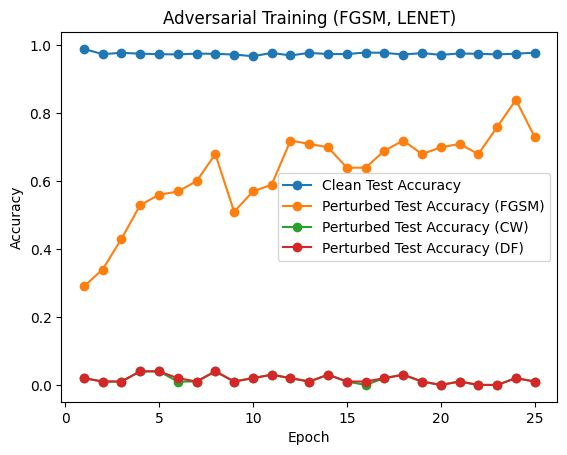

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
import matplotlib.pyplot as plt

# Load the clean training dataset
(_, _), (train_images, train_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images / 255.0  # Normalize pixel values

# Load the clean test dataset
(_, _), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = test_images / 255.0  # Normalize pixel values

# Load the FCN model (replace with your model loading code)
fcn_model = models.load_model("../Models/Mnist/mnist_model_LENET.karas")

# Compile the model
fcn_model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

# Adversarial training parameters
epochs = 25
batch_size = 16
epsilon_fgs = 0.25  # FGSM epsilon value

# Lists to store accuracy for plotting
clean_test_accuracies = []
perturbed_test_accuracies_FGSM = []
perturbed_test_accuracies_CW = []
perturbed_test_accuracies_DF = []

# Define an epsilon value for the C&W untargeted attack
epsilon = 0.005
max_iter=50
learning_rate = 0.1

# Define parameters for the Deepfool attack
max_iter = 50
epsilon = 0.005

# Adversarial training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Randomly select a subset of 500 training samples
    indices_train = np.random.choice(len(train_images), 500, replace=False)
    train_images_200 = train_images[indices_train]
    perturbed_train_images = np.array([generate_fgsm(image, fcn_model, epsilon_fgs) for image in train_images_200])
    perturbed_train_labels = train_labels[indices_train]

    # Randomly select a subset of 100 testing samples and generate adversarial examples
    indices_test = np.random.choice(len(test_images), 100, replace=False)
    test_images_200 = test_images[indices_test]
    #FGSM
    perturbed_test_images_FGSM = np.array([generate_fgsm(image, fcn_model, epsilon_fgs) for image in test_images_200])
    perturbed_test_labels_FGSM = test_labels[indices_test]
    #CW
    perturbed_test_images_CW = np.array([generate_carlini_l2(image, fcn_model, epsilon, max_iter, learning_rate) for image in test_images_200])
    perturbed_test_labels_CW = test_labels[indices_test]
    #DF
    perturbed_test_images_DF = np.array([generate_deepfool(image, fcn_model, epsilon, max_iter) for image in test_images_200])
    perturbed_test_labels_DF = test_labels[indices_test]

    # Evaluate on clean test set
    test_loss, clean_test_accuracy = fcn_model.evaluate(test_images, test_labels)
    clean_test_accuracies.append(clean_test_accuracy)

    # Evaluate on perturbed test sets
    perturbed_test_accuracy_FGSM = fcn_model.evaluate(perturbed_test_images_FGSM, perturbed_test_labels_FGSM, verbose=2)[1]
    perturbed_test_accuracies_FGSM.append(perturbed_test_accuracy_FGSM)
    perturbed_test_accuracy_CW = fcn_model.evaluate(perturbed_test_images_CW, perturbed_test_labels_CW, verbose=2)[1]
    perturbed_test_accuracies_CW.append(perturbed_test_accuracy_CW)
    perturbed_test_accuracy_DF = fcn_model.evaluate(perturbed_test_images_DF, perturbed_test_labels_DF, verbose=2)[1]
    perturbed_test_accuracies_DF.append(perturbed_test_accuracy_DF)

    # Train on perturbed examples
    fcn_model.fit(perturbed_train_images, perturbed_train_labels, epochs=1, batch_size=batch_size, verbose=2)

# Plot the results
plt.plot(range(1, epochs+1), clean_test_accuracies, label='Clean Test Accuracy', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_FGSM, label='Perturbed Test Accuracy (FGSM)', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_CW, label='Perturbed Test Accuracy (CW)', marker='o')
plt.plot(range(1, epochs+1), perturbed_test_accuracies_DF, label='Perturbed Test Accuracy (DF)', marker='o')
plt.title('Adversarial Training (FGSM, LENET)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [76]:
fcn_model.save("../Models/Mnist/mnist_model_LENET_ADV_FGSM.karas")

INFO:tensorflow:Assets written to: ../Models/Mnist/mnist_model_LENET_ADV_FGSM.karas\assets


INFO:tensorflow:Assets written to: ../Models/Mnist/mnist_model_LENET_ADV_FGSM.karas\assets
